# **Testing Deep Learning Architectures for Seismic Event Classification**

### **Author**: Akash Kharita  
### **Last Updated**: October 7, 2024  

---

## **Purpose**
This notebook implements and evaluates various deep learning architectures for classifying seismic events. The dataset includes different seismic sources such as:
- Earthquakes
- Explosions
- Surface events
- Noise

The notebook performs the following tasks:
1. Prepares waveform and spectrogram data from seismic datasets.
2. Trains multiple deep learning models, including custom 1D and 2D convolutional neural networks (CNNs) and residual CNNs.
3. Evaluates the models using metrics such as loss, accuracy, confusion matrices, and classification reports.

---

## **Contents**
1. [Setup and Imports](#Setup-and-Imports)
2. [Metadata Loading](#Metadata-Loading)
3. [Filtered by Signal-to-Noise Ratio (SNR)](#Filtered-by-Signal-to-Noise-Ratio-(SNR))
4. [Extracting Waveform Data](#Extracting-Waveform-Data)
5. [Preparing Input Data (1D and 2D)](#Preparing-Input-Data)
6. [Creating Dataloaders](#Creating-Dataloaders)
7. [Model Training and Evaluation](#Model-Training-and-Evaluation)
    - [SeismicCNN 1D](#SeismicCNN-1D)
    - [SeismicCNN 2D](#SeismicCNN-2D)
    - [QuakeXNet 1D](#QuakeXNet-1D)
    - [QuakeXNet 2D](#QuakeXNet-2D)
    - [QuakeXNet 1D on 2D](#QuakeXNet-1D-on-2D)
    - [BasicResNet 1D](#BasicResNet-1D)
    - [BasicResNet 2D](#BasicResNet-2D)



## Setup and Imports
This section imports all necessary libraries and modules. It also sets up the environment, including:
- Adding custom scripts to the Python path.
- Checking if a GPU is available for training.

Key libraries used:
- **PyTorch**: For building and training neural networks.
- **ObsPy**: For handling seismic data.
- **NumPy and Pandas**: For data processing.
- **Matplotlib**: For plotting and visualizing results.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import sys
import os
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset



import numpy as np
import scipy.signal as signal



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Get the current working directory
notebook_dir = os.getcwd()

# Add the ../src directory to the Python path
src_path = os.path.abspath(os.path.join(notebook_dir, 'scripts'))
sys.path.insert(0, src_path)

from neural_network_architectures import QuakeXNet_1d
from neural_network_architectures import QuakeXNet_2d
from neural_network_architectures import QuakeXNet_1d_on_2d

from neural_network_architectures import SeismicCNN_1d
from neural_network_architectures import SeismicCNN_2d

from neural_network_architectures import BasicResNet_1d
from neural_network_architectures import BasicResNet_2d


from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr
from helper_functions import return_train_val_loaders

import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
cuda
cuda


## Metadata loading
Loads metadata for seismic event classes from CSV files:
- `comcat_metadata`: Metadata for earthquake and explosion events.
- `exotic_metadata`: Metadata for surface events.
- `noise_metadata`: Metadata for noise samples.

Metadata is filtered to create separate dataframes for:
- Earthquakes
- Explosions
- Surface events
- Noise

In [3]:
#data files
file_noise="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


## Filtered by Signal-to-Noise Ratio (SNR)
Applies a threshold-based filter to exclude low-SNR events:
- SNR threshold (`SNR_THR`) is set to 1 for explosions and earthquakes.
- A slightly lower threshold is used for surface events.

Filtered metadata ensures higher-quality waveforms are used for training.

In [4]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

## Merging the additionally downloaded surface event data

In [5]:
num_channels = 3
# new sampling rate
fs = 50

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100

start = -20


## Processing the data first

The following cell takes the already downloaded and stored dataset and process it in a format similar to other events

In [6]:
def process_surface_events(data_path, ids_path, fs=50, lowcut=1, highcut=20, window_length=100, taper_alpha=0.1, random_offset=(-20, -5)):
    """
    Processes surface event data by applying tapering, bandpass filtering, resampling, and normalization.
    
    Args:
        data_path (str): Path to the surface event data (.npy file).
        ids_path (str): Path to the surface event IDs (JSON file).
        fs (int): Sampling rate for resampling.
        lowcut (float): Low cutoff frequency for bandpass filter.
        highcut (float): High cutoff frequency for bandpass filter.
        window_length (int): Length of the waveform window (in seconds).
        taper_alpha (float): Alpha value for the Tukey window.
        random_offset (tuple): Range of random offsets for slicing data.
        
    Returns:
        list: Processed waveform data.
        list: Corresponding event IDs.
    """
    # Load data and IDs
    surface_data = np.load(data_path, allow_pickle=True)
    with open(ids_path, "r") as file:
        surface_ids = json.load(file)

    nyquist = 0.5 * 100  # Nyquist frequency (original sampling rate is 100 Hz)
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients

    processed_data = []
    processed_ids = []

    # Process each event
    for i in tqdm(range(len(surface_data)), desc="Processing events"):
        try:
            event_data = surface_data[i]

            # Apply a Tukey taper to the signal
            taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
            tapered_data = np.array([np.multiply(taper, row) for row in event_data])

            # Apply bandpass filtering
            filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])

            # Resample the data to the target sampling rate
            num_samples = int(filtered_data.shape[1] * fs / 100)  # Resample to target `fs`
            resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

            # Randomly select a window of the specified length
            random_shift = np.random.randint(random_offset[0], random_offset[1]) * fs
            start_idx = int(90 * fs) + random_shift
            end_idx = start_idx + int(window_length * fs)

            # Handle boundary conditions
            max_idx = resampled_data.shape[1]
            if end_idx > max_idx:
                end_idx = max_idx
                start_idx = end_idx - int(window_length * fs)
            if start_idx < 0:
                start_idx = 0
                end_idx = int(window_length * fs)

            # Normalize the selected window
            selected_window = resampled_data[:, start_idx:end_idx]
            normalization_factor = np.std(np.abs(selected_window))
            if len(event_data) == 3:  # Ensure the event has three components
                processed_data.append(selected_window / normalization_factor)
                processed_ids.append(surface_ids[i])

        except Exception as e:
            # Log or print the exception if needed
            print(f"Error processing event {i}: {e}")
            continue

    return processed_data, processed_ids


# Example usage
data_path = '../data/new_curated_surface_event_data.npy'
ids_path = '../data/new_curated_surface_event_ids.json'

processed, processed_id = process_surface_events(data_path, ids_path)


Processing events: 100%|██████████| 6495/6495 [00:20<00:00, 318.46it/s]


## Extracting Waveform Data
Waveforms are extracted from `.hdf5` files using the `extract_waveforms` function. Key parameters:
- **Number of channels**: 3 (e.g., Z, N, E components)
- **Sampling rate**: 50 Hz
- **Window length**: 100 samples
- **Bandpass filter**: 1–20 Hz

Each event class (earthquakes, explosions, surface events, noise) is balanced to contain an equal number of samples.


In [7]:

nos = 2000

# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = -20
shifting = True

# training parameters
train_split = 70                                      
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()




number_data_per_class = 8434
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)



number_data_per_class = 15000
# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



number_data_per_class = len(df_exp)
# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)


number_data_per_class = 17000
# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)


  0%|          | 7/15000 [00:00<03:45, 66.56it/s]

(3712, 3, 5000)


  0%|          | 16/13638 [00:00<01:25, 159.48it/s]

(10652, 3, 5000)


  0%|          | 0/17000 [00:00<?, ?it/s]

(10027, 3, 5000)


100%|██████████| 17000/17000 [05:09<00:00, 54.95it/s]


(11410, 3, 5000)


## Creating a common test and train dataset

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(d_eq, d_exp, d_noise, d_su, processed, processed_ids, num_samples=10000):
    """
    Prepares and concatenates seismic data for training and testing.
    
    Args:
        d_eq, d_exp, d_noise, d_su (array): Arrays of waveform data for different classes.
        processed (array): Processed surface waveforms.
        processed_ids (array): Corresponding IDs for processed surface waveforms.
        num_samples (int): Number of samples to extract per class.

    Returns:
        tuple: Combined waveforms (new_X_1d), event IDs (new_X), and labels (new_y).
    """
    # Extract the required number of samples per class
    new_d_eq = d_eq[:num_samples]
    new_d_exp = d_exp[:num_samples]
    new_d_no = d_noise[:num_samples]
    new_d_su = np.concatenate([d_su, np.array(processed)])[:num_samples]

    # Extract corresponding event IDs
    new_id_eq = id_eq[:num_samples]
    new_id_exp = id_exp[:num_samples]
    new_id_no = id_noise[:num_samples]
    new_id_su = np.concatenate([id_su, np.array(processed_ids)])[:num_samples]

    # Combine data into single arrays
    new_X_1d = np.vstack([new_d_eq, new_d_exp, new_d_no, new_d_su])  # Waveforms
    new_X = np.hstack([new_id_eq, new_id_exp, new_id_no, new_id_su])  # Event IDs
    new_y = (
        [0] * len(new_d_eq) + 
        [1] * len(new_d_exp) + 
        [2] * len(new_d_no) + 
        [3] * len(new_d_su)
    )  # Labels
    
    return new_X_1d, new_X, new_y

def split_and_save_data(new_X, new_X_1d, new_y, test_size=0.2, random_state=42, save_path="../data"):
    """
    Splits data into training and testing, and saves the results to disk.
    
    Args:
        new_X (array): Event IDs.
        new_X_1d (array): Waveform data.
        new_y (list): Labels for the event IDs.
        test_size (float): Proportion of test data.
        random_state (int): Random state for reproducibility.
        save_path (str): Directory to save the test data IDs.
    """
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        new_X, new_y, test_size=test_size, random_state=random_state, stratify=new_y
    )
    
    # Create a mapping of event IDs to indices
    event_id_to_index = {event_id: idx for idx, event_id in enumerate(new_X)}
    
    # Retrieve indices for test and train data
    test_indices = [event_id_to_index[event_id] for event_id in X_test]
    train_indices = [event_id_to_index[event_id] for event_id in X_train]
    
    # Extract waveforms for train and test sets
    test_waveforms = new_X_1d[test_indices]
    train_waveforms = new_X_1d[train_indices]
    
    # Save test data IDs for future use
    np.save(f"{save_path}/common_test_data_id.npy", X_test)
    np.save(f"{save_path}/common_test_data_for_deep_learning.npy", test_waveforms)
    np.save(f"{save_path}/common_test_data_labels_for_deep_learning.npy", y_test)
    
    print("Shape of test_waveforms:", test_waveforms.shape)
    print("Shape of train_waveforms:", train_waveforms.shape)

    return train_waveforms, test_waveforms, y_train, y_test


# Example usage:
new_X_1d, new_X, new_y = prepare_data(d_eq, d_exp, d_noise, d_su, processed, processed_id, num_samples=10000)
train_waveforms, test_waveforms, y_train, y_test = split_and_save_data(new_X, new_X_1d, new_y)


Shape of test_waveforms: (8000, 3, 5000)
Shape of train_waveforms: (32000, 3, 5000)


## Preparing Input Data
1. **1D Input**:
    - Waveforms are concatenated to create a 1D input dataset (`X_1d`).
2. **2D Input**:
    - Spectrograms are generated using the `extract_spectrograms` function.
    - These are concatenated to create a 2D input dataset (`X_2d`).


In [9]:
# concatenate all data into one input
X_1d = train_waveforms
X_2d = extract_spectrograms(waveforms = train_waveforms)
y = y_train

100%|██████████| 32000/32000 [00:30<00:00, 1056.75it/s]

(32000, 3, 129, 38)


## Creating Dataloaders
Dataloaders are prepared for both 1D and 2D inputs using the `return_train_test_val_loaders` function. The dataset is split into:
- **Training set**: 70%
- **Validation set**: 20%
- **Test set**: 10%

Batch size is set to 128.

In [10]:
train_split =75
val_split = 25

train_loader_1d, val_loader_1d = return_train_val_loaders(X = X_1d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)
train_loader_2d, val_loader_2d = return_train_val_loaders(X = X_2d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)


187 62
187 62


## Model Training and Evaluation
Trains and evaluates various models using the `train_model` function. Metrics include:
- Training and validation loss
- Validation and test accuracy
- Confusion matrices and classification reports

### **7.1 SeismicCNN 1D**
- Architecture: 1D CNN
- Input: `X_1d`
- Results:
  - Plots training/validation loss and accuracy over epochs.
  - Displays confusion matrix and classification report.

### **7.2 SeismicCNN 2D**
- Architecture: 2D CNN
- Input: `X_2d`
- Results:
  - Similar to SeismicCNN 1D but processes spectrogram inputs.

### **7.3 QuakeXNet 1D**
- Architecture: Custom 1D CNN
- Input: `X_1d`
- Results:
  - Training/validation loss and accuracy plots.
  - Confusion matrix and classification report.

### **7.4 QuakeXNet 2D**
- Architecture: Custom 2D CNN
- Input: `X_2d`
- Results:
  - Similar to MyCNN 1D but processes spectrogram inputs.

### **7.5 QuakeXNet 1D on 2D**
- Architecture: Custom 1D CNN applied to spectrograms.
- Input: `X_2d`
- Results:
  - Evaluates how well a 1D CNN can process spectrogram data.

### **7.6 BasicResNet 1D**
- Architecture: Residual 1D CNN
- Input: `X_1d`
- Results:
  - Demonstrates the power of residual connections in 1D architectures.

### **7.7 BasicResNet 2D**
- Architecture: Residual 2D CNN
- Input: `X_2d`
- Results:
  - Evaluates the performance of a 2D residual architecture on spectrogram inputs.
  

## **Visualization**
Each model training process includes:
- Loss and accuracy plots.
- Confusion matrices to show classification performance.


## SeismicCNN 1D

In [11]:
n_epochs = 100
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d, model_training_time_seismiccnn_1d) = train_model(model_seismiccnn_1d,
    train_loader_1d,  
    val_loader_1d,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,
    augmentation= False, 
    patience = 30, 
    model_path = 'trained_models/best_model_')

 10%|█         | 10/100 [00:43<06:21,  4.24s/it]

[Epoch 10] loss: 0.169 - accuracy: 80.015


 20%|██        | 20/100 [01:24<05:28,  4.11s/it]

[Epoch 20] loss: 0.064 - accuracy: 82.409


 30%|███       | 30/100 [02:06<04:59,  4.28s/it]

[Epoch 30] loss: 0.037 - accuracy: 84.866


 40%|████      | 40/100 [02:46<04:03,  4.06s/it]

[Epoch 40] loss: 0.029 - accuracy: 85.723


 41%|████      | 41/100 [02:54<04:11,  4.26s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:503: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

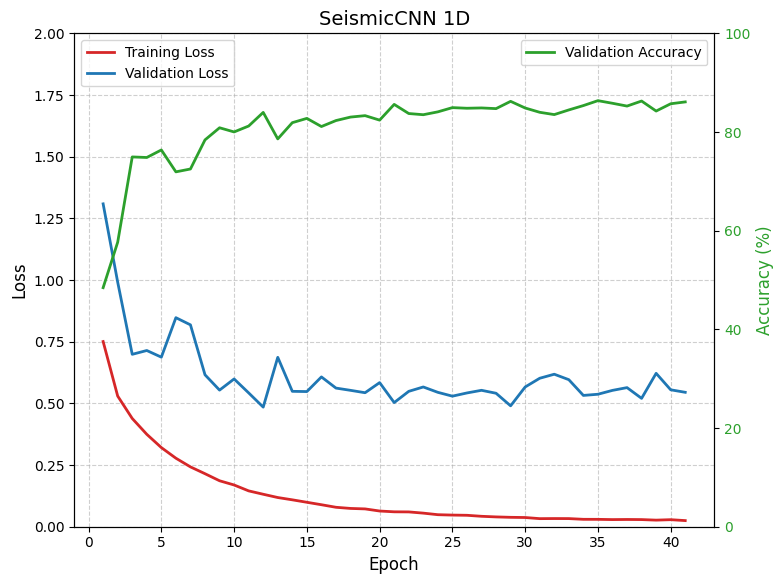

In [14]:
def plot_model_training(loss_time, val_loss_time, val_accuracy_time, title = 'SeismicCNN 1D'):


    # Assuming loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy are defined

    NN = np.count_nonzero(loss_time)
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability

    # Set font sizes
    plt.style.use('default')
    plt.rc('font', size=12)  # Global font size
    plt.rc('axes', titlesize=14)  # Title font size
    plt.rc('axes', labelsize=12)  # Axis label font size
    plt.rc('xtick', labelsize=10)  # X-axis tick label font size
    plt.rc('ytick', labelsize=10)  # Y-axis tick label font size

    # Plot Training and Validation Loss
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.plot(np.arange(1, NN), loss_time[:NN-1], color='tab:red', label='Training Loss', linewidth=2)
    ax1.plot(np.arange(1, NN), val_loss_time[:NN-1], color='tab:blue', label='Validation Loss', linewidth=2)
    #ax1.plot(NN+1, test_loss, 'p', color='tab:blue', label='Test Loss', markersize=10)
    ax1.set_ylim(0, 2)
    ax1.grid(True, linestyle='--', alpha=0.6)  # Add grid with some transparency

    # Twin axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='tab:green')
    ax2.plot(np.arange(1, NN), val_accuracy_time[:NN-1], color='tab:green', label='Validation Accuracy', linewidth=2)
    #ax2.plot(NN+1, test_accuracy, 's', color='tab:green', label='Test Accuracy', markersize=10)
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.grid(False)

    # Title and legend
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add legends for both axes
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Save the figure with high resolution
    plt.savefig(f"../figures/{title}", dpi=300, bbox_inches='tight')

    plt.show()

plot_model_training(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d)

test loss: 0.486 and accuracy: 83.909


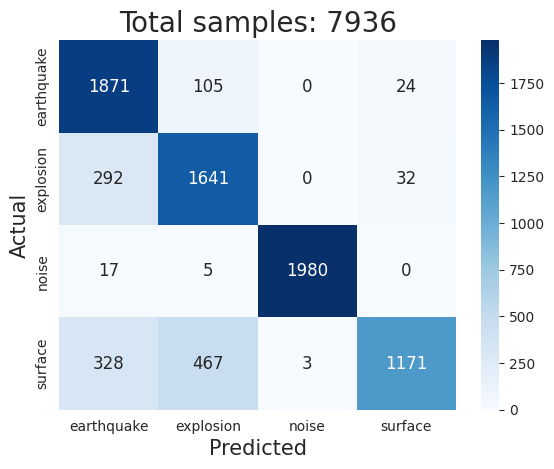

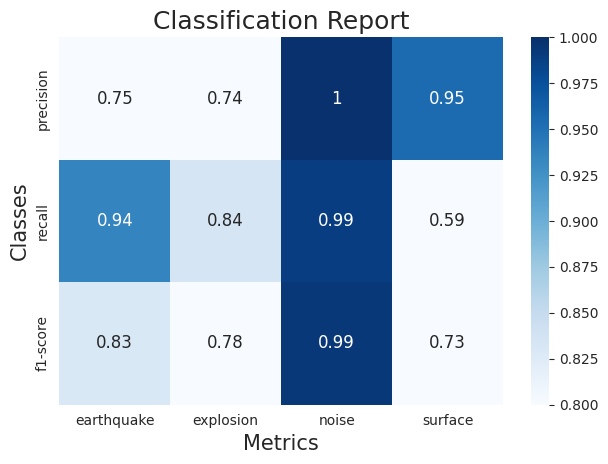

In [30]:
import seaborn
cm_seismiccnn_1d, cr_seismiccnn_1d = plot_confusion_matrix_and_cr(model_seismiccnn_1d, val_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## SeismicCNN 2D

In [18]:
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, model_training_time_seismiccnn_2d) = train_model(model_seismiccnn_2d,
    train_loader_2d,  
    val_loader_2d, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'trained_models/best_model_' )

 10%|█         | 10/100 [01:06<09:38,  6.43s/it]

[Epoch 10] loss: 0.297 - accuracy: 89.579


 20%|██        | 20/100 [02:18<09:44,  7.30s/it]

[Epoch 20] loss: 0.201 - accuracy: 92.414


 30%|███       | 30/100 [03:10<04:54,  4.21s/it]

[Epoch 30] loss: 0.149 - accuracy: 92.918


 40%|████      | 40/100 [03:50<04:14,  4.24s/it]

[Epoch 40] loss: 0.123 - accuracy: 93.296


 50%|█████     | 50/100 [04:33<03:35,  4.30s/it]

[Epoch 50] loss: 0.109 - accuracy: 93.939


 60%|██████    | 60/100 [05:08<02:14,  3.36s/it]

[Epoch 60] loss: 0.090 - accuracy: 93.674


 70%|███████   | 70/100 [05:43<01:46,  3.54s/it]

[Epoch 70] loss: 0.085 - accuracy: 93.170


 72%|███████▏  | 72/100 [05:53<02:17,  4.91s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:503: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

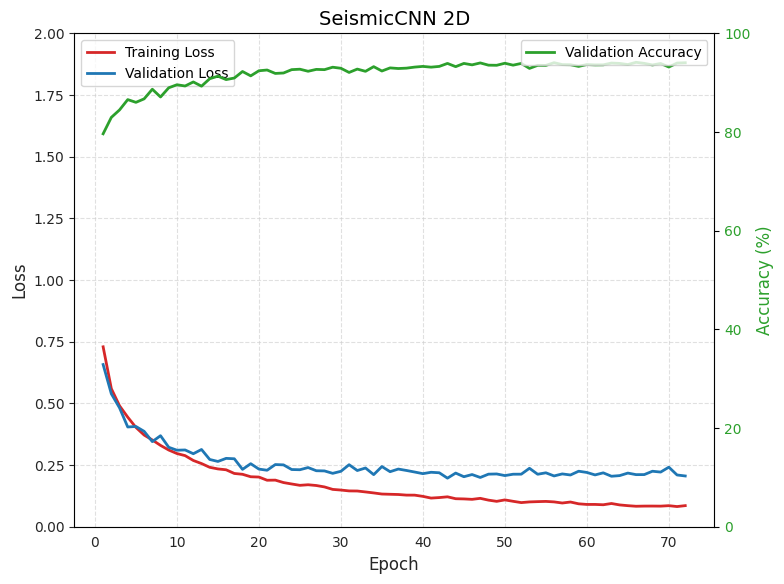

In [19]:
plot_model_training(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, title = 'SeismicCNN 2D')

test loss: 0.197 and accuracy: 93.876


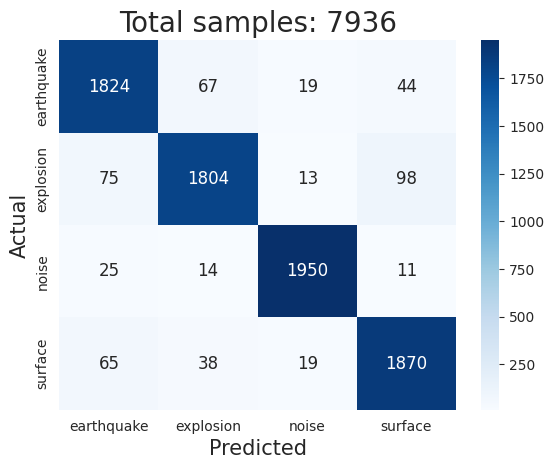

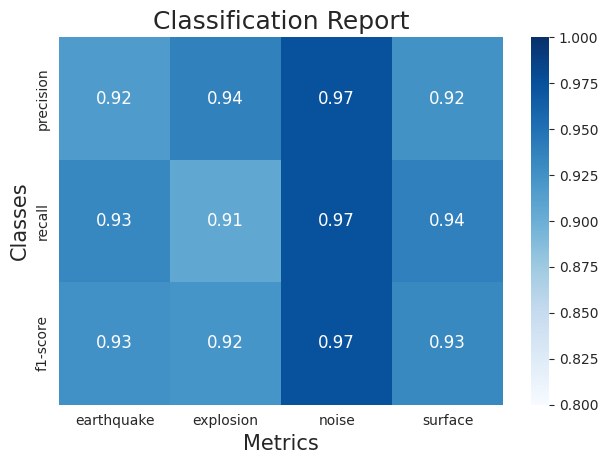

In [31]:
model_seismiccnn_2d.eval()
cm_seismiccnn_2d, cr_seismiccnn_2d = plot_confusion_matrix_and_cr(model_seismiccnn_2d, val_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## QuakeXNet 1D

In [21]:
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_1d, val_loss_time_mycnn_1d, val_accuracy_time_mycnn_1d, model_training_time_quakexnet_1d) = train_model(model_quakexnet_1d,
    train_loader_1d,  val_loader_1d, n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'trained_models/best_model_')

 10%|█         | 10/100 [00:36<05:43,  3.82s/it]

[Epoch 10] loss: 0.279 - accuracy: 87.135


 20%|██        | 20/100 [01:12<04:47,  3.59s/it]

[Epoch 20] loss: 0.209 - accuracy: 88.521


 30%|███       | 30/100 [01:49<04:17,  3.68s/it]

[Epoch 30] loss: 0.171 - accuracy: 89.667


 40%|████      | 40/100 [02:30<03:38,  3.64s/it]

[Epoch 40] loss: 0.146 - accuracy: 91.356


 50%|█████     | 50/100 [03:07<03:00,  3.61s/it]

[Epoch 50] loss: 0.127 - accuracy: 92.112


 60%|██████    | 60/100 [03:44<02:33,  3.84s/it]

[Epoch 60] loss: 0.111 - accuracy: 91.545


 70%|███████   | 70/100 [04:20<01:48,  3.60s/it]

[Epoch 70] loss: 0.096 - accuracy: 90.713


 77%|███████▋  | 77/100 [04:49<01:26,  3.76s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:503: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

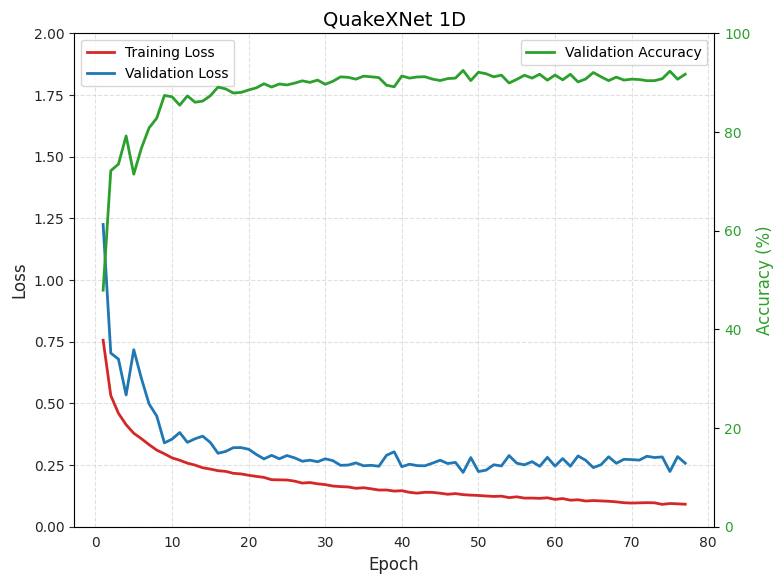

In [22]:
plot_model_training(loss_time_mycnn_1d, val_loss_time_mycnn_1d, val_accuracy_time_mycnn_1d, title = 'QuakeXNet 1D')

test loss: 0.221 and accuracy: 92.452


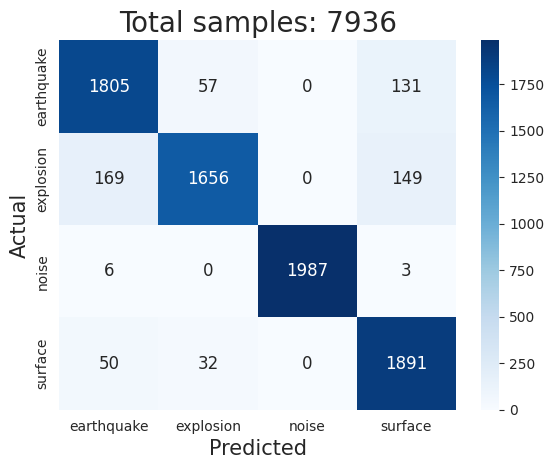

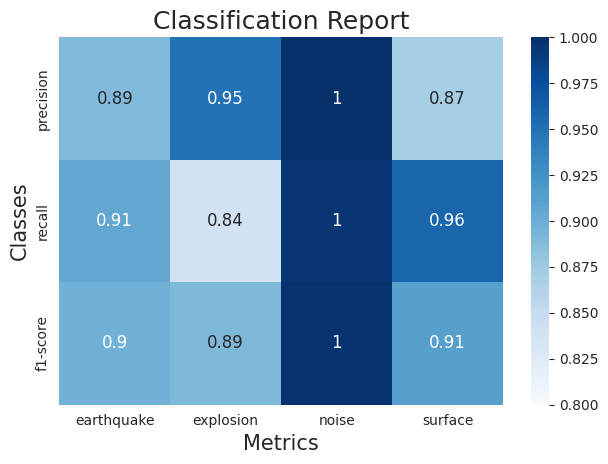

In [32]:
model_quakexnet_1d.eval()
cm_quakexnet_1d, cr_quakexnet_1d = plot_confusion_matrix_and_cr(model_quakexnet_1d, val_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## QuakeXNet 2D

In [38]:
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_2d, val_loss_time_mycnn_2d, val_accuracy_time_mycnn_2d, model_training_time_quakexnet_2d) = train_model(model_quakexnet_2d,
    train_loader_2d,  
    val_loader_2d, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'trained_models/best_model_')

 10%|█         | 10/100 [01:04<10:06,  6.74s/it]

[Epoch 10] loss: 0.439 - accuracy: 87.689


 20%|██        | 20/100 [02:13<09:57,  7.47s/it]

[Epoch 20] loss: 0.358 - accuracy: 89.831


 30%|███       | 30/100 [03:06<05:14,  4.49s/it]

[Epoch 30] loss: 0.326 - accuracy: 90.461


 40%|████      | 40/100 [03:45<03:45,  3.76s/it]

[Epoch 40] loss: 0.314 - accuracy: 90.890


 50%|█████     | 50/100 [04:23<03:00,  3.62s/it]

[Epoch 50] loss: 0.297 - accuracy: 91.381


 60%|██████    | 60/100 [05:01<02:40,  4.01s/it]

[Epoch 60] loss: 0.293 - accuracy: 92.440


 70%|███████   | 70/100 [06:02<03:11,  6.37s/it]

[Epoch 70] loss: 0.293 - accuracy: 92.150


 80%|████████  | 80/100 [06:52<01:35,  4.77s/it]

[Epoch 80] loss: 0.282 - accuracy: 91.494


 90%|█████████ | 90/100 [07:35<00:42,  4.23s/it]

[Epoch 90] loss: 0.275 - accuracy: 90.801


100%|██████████| 100/100 [08:20<00:00,  5.01s/it]

[Epoch 100] loss: 0.273 - accuracy: 92.918



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:503: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

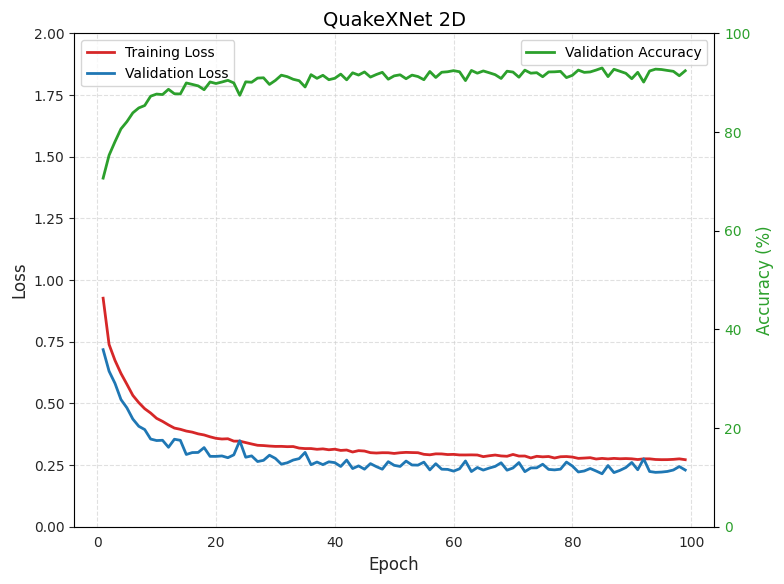

In [41]:
plot_model_training(loss_time_mycnn_2d, val_loss_time_mycnn_2d, val_accuracy_time_mycnn_2d, title = 'QuakeXNet 2D')

test loss: 0.215 and accuracy: 92.944


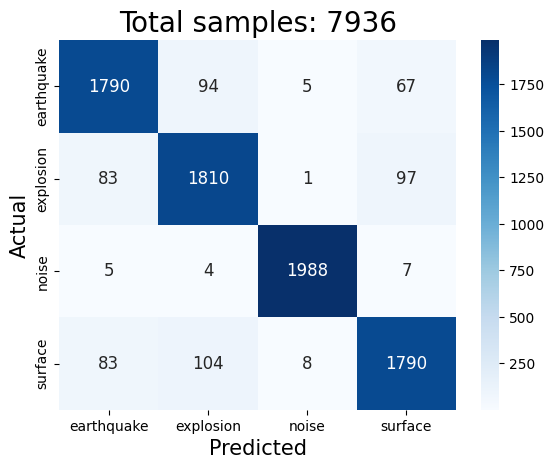

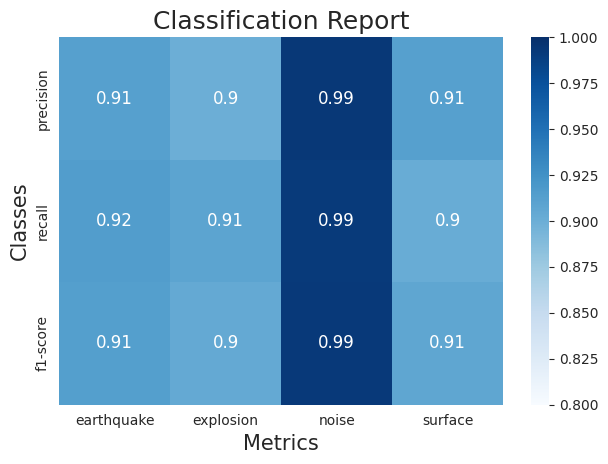

In [42]:
model_quakexnet_2d.eval()
cm_quakexnet_2d, cr_quakexnet_2d = plot_confusion_matrix_and_cr(model_quakexnet_2d, val_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## BasicResNet 1D

In [40]:
model_basicresnet_1d = BasicResNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_myrescnn_1d, val_loss_time_myrescnn_1d, val_accuracy_time_myrescnn_1d, model_training_time_myresnet_1d) = train_model(model_basicresnet_1d,
    train_loader_1d,  val_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 10%|█         | 10/100 [00:48<07:17,  4.86s/it]

[Epoch 10] loss: 0.471 - accuracy: 64.289


 20%|██        | 20/100 [01:37<06:28,  4.86s/it]

[Epoch 20] loss: 0.418 - accuracy: 70.980


 30%|███       | 30/100 [02:26<05:41,  4.88s/it]

[Epoch 30] loss: 0.380 - accuracy: 69.153


 40%|████      | 40/100 [03:14<04:52,  4.88s/it]

[Epoch 40] loss: 0.354 - accuracy: 67.981


 50%|█████     | 50/100 [04:03<04:03,  4.86s/it]

[Epoch 50] loss: 0.335 - accuracy: 68.322


 60%|██████    | 60/100 [04:52<03:15,  4.88s/it]

[Epoch 60] loss: 0.320 - accuracy: 63.810


 60%|██████    | 60/100 [04:57<03:18,  4.96s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:497: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

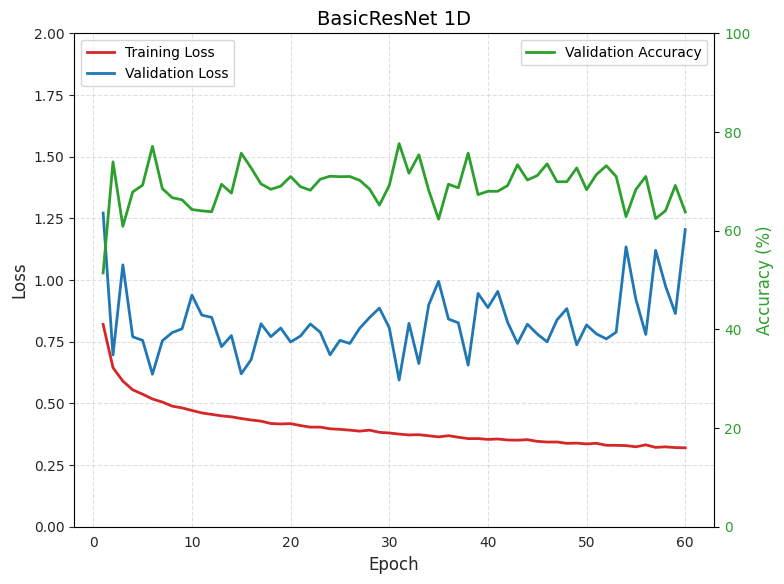

In [42]:
plot_model_training(loss_time_myrescnn_1d, val_loss_time_myrescnn_1d, val_accuracy_time_myrescnn_1d, title = 'BasicResNet 1D')









test loss: 0.594 and accuracy: 77.709


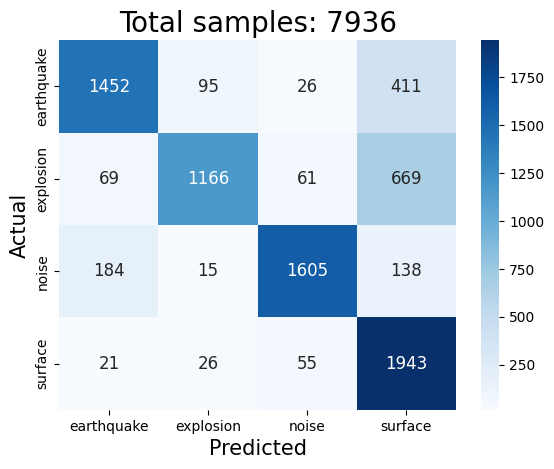

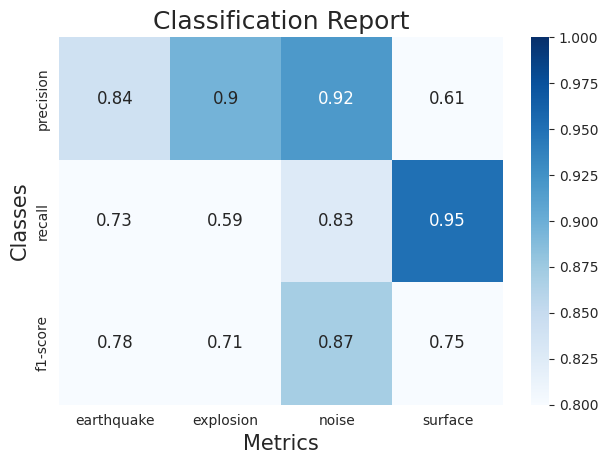

In [43]:
model_basicresnet_1d.eval()
_,_ = plot_confusion_matrix_and_cr(model_basicresnet_1d, val_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## BasicResNet 2D

In [44]:
model_basicresnet_2d = BasicResNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_myrescnn_2d, val_loss_time_myrescnn_2d, val_accuracy_time_myrescnn_2d, model_training_time_myresnet_2d) = train_model(model_basicresnet_2d,
    train_loader_2d,  val_loader_2d, n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 10%|█         | 10/100 [00:29<04:21,  2.90s/it]

[Epoch 10] loss: 0.221 - accuracy: 92.654


 20%|██        | 20/100 [00:59<03:59,  2.99s/it]

[Epoch 20] loss: 0.159 - accuracy: 93.296


 30%|███       | 30/100 [01:29<03:28,  2.97s/it]

[Epoch 30] loss: 0.119 - accuracy: 93.196


 40%|████      | 40/100 [02:00<03:00,  3.00s/it]

[Epoch 40] loss: 0.097 - accuracy: 93.687


 50%|█████     | 50/100 [02:34<02:52,  3.45s/it]

[Epoch 50] loss: 0.082 - accuracy: 92.427


 60%|██████    | 60/100 [03:04<02:04,  3.12s/it]

[Epoch 60] loss: 0.071 - accuracy: 94.342


 60%|██████    | 60/100 [03:07<02:05,  3.13s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:497: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

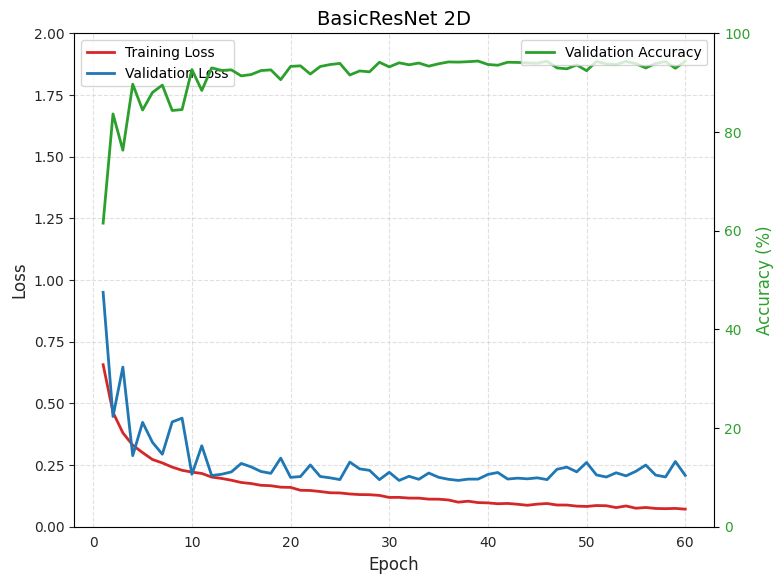

In [45]:
plot_model_training(loss_time_myrescnn_2d, val_loss_time_myrescnn_2d, val_accuracy_time_myrescnn_2d, title = 'BasicResNet 2D')





test loss: 0.186 and accuracy: 94.040


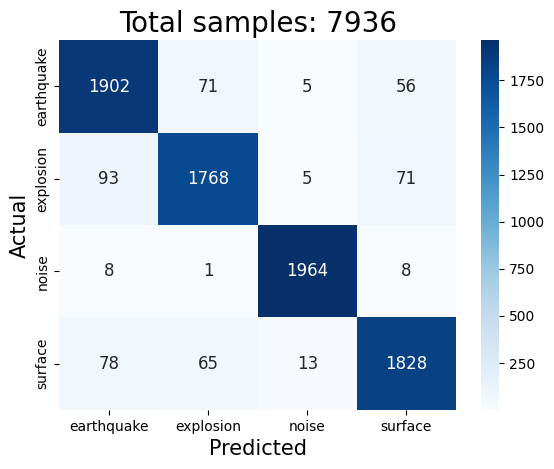

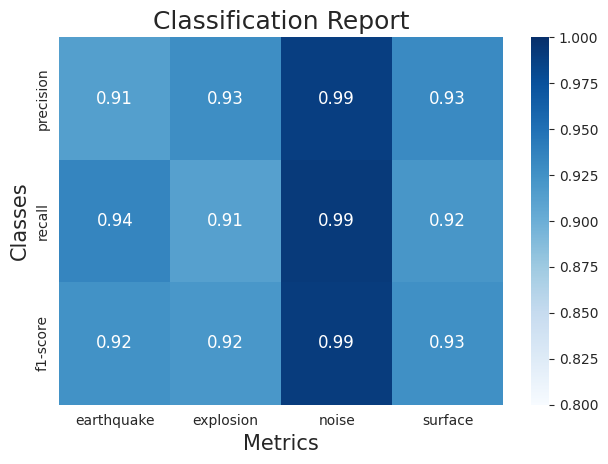

In [46]:
model_basicresnet_2d.eval()
_,_  = plot_confusion_matrix_and_cr(model_basicresnet_2d, val_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

In [55]:
# Print the summary
import torchsummary
print('SeismicCNN(1D) Architecture')
torchsummary.summary(model_seismiccnn_1d, input_size=(3,5000))

print('SeismicCNN(2D) Architecture')
torchsummary.summary(model_seismiccnn_2d, input_size=(3,129,38))

print('QuakeXNet (1D) Architecture')
torchsummary.summary(model_quakexnet_1d, input_size=(3,5000))

print('QuakeXNet(2D) Architecture')
torchsummary.summary(model_quakexnet_2d, input_size=(3,129,38))



SeismicCNN(1D) Architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 4996]             512
       BatchNorm1d-2             [-1, 32, 4996]              64
         MaxPool1d-3             [-1, 32, 2498]               0
           Dropout-4             [-1, 32, 2498]               0
            Conv1d-5             [-1, 64, 2494]          10,304
       BatchNorm1d-6             [-1, 64, 2494]             128
         MaxPool1d-7             [-1, 64, 1247]               0
           Dropout-8             [-1, 64, 1247]               0
            Linear-9                  [-1, 128]      10,215,552
      BatchNorm1d-10                  [-1, 128]             256
          Dropout-11                  [-1, 128]               0
           Linear-12                    [-1, 4]             516
      BatchNorm1d-13                    [-1, 4]               8
Total param

## Saving the validation results

In [43]:
import pickle


## seismiccnn_1d
holder = '_seismiccnn_1d'

# saving model training time 
with open('../results/model_training_time'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(model_training_time_seismiccnn_1d, pickle_file)


# saving trace wise report
with open('../results/trace_report'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cr_seismiccnn_1d, pickle_file)

# saving trace wise confusion matrix
with open('../results/trace_confusion_matrix'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cm_seismiccnn_1d, pickle_file)
    
    

## seismiccnn_2d
holder = '_seismiccnn_2d'

# saving model training time 
with open('../results/model_training_time'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(model_training_time_seismiccnn_2d, pickle_file)


# saving trace wise report
with open('../results/trace_report'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cr_seismiccnn_2d, pickle_file)

# saving trace wise confusion matrix
with open('../results/trace_confusion_matrix'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cm_seismiccnn_2d, pickle_file)


    
    
## quakexnet_1d
holder = '_quakexnet_1d'

# saving model training time 
with open('../results/model_training_time'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(model_training_time_quakexnet_1d, pickle_file)


# saving trace wise report
with open('../results/trace_report'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cr_quakexnet_1d, pickle_file)

# saving trace wise confusion matrix
with open('../results/trace_confusion_matrix'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cm_quakexnet_1d, pickle_file)

    
    
## quakexnet_1d
holder = '_quakexnet_2d'

# saving model training time 
with open('../results/model_training_time'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(model_training_time_quakexnet_2d, pickle_file)


# saving trace wise report
with open('../results/trace_report'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cr_quakexnet_2d, pickle_file)

# saving trace wise confusion matrix
with open('../results/trace_confusion_matrix'+holder+'.pkl', 'wb') as pickle_file:
    pickle.dump(cm_quakexnet_2d, pickle_file)